In [1]:
from collections import Counter
import functools
import itertools as it
import os
import re
import string

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from utils import *
from topic_utils import *

In [2]:
pd.set_option('display.max_colwidth', 150)

# reproducible rng
seed = 0

plt.style.use("bmh")
%matplotlib inline

# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

### Data

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [4]:
user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head(5)

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,"[America and the way its government treats its people must be reformed https://t.co/DupN3cE2dd, https://t.co/ee5KZJMm5R, Portland Police Bureau is..."
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکنه خاک تو سرش.\nلطفا کسانی که واسه ایران و مردم سیل زده کمک نکردند نظر ندن.\n\n🔘پهباد سه تا ۱۰۰۰۰۰ یو...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,"[People are not silent! This structure must change!\n#PortlandProtest\nhttps://t.co/qydIlgjWK6, Hello bankrupt economy ..... Goodbye Trump #TrumpH..."
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una importante carretera en Brasil para protestar tanto contra la deforestación del Amazonas.\n#Brasileirao \n#Bo...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an rapest Pedophile This is really worrying and encourages rape of women. Every vote for Biden = Vote f...


### Vectorize

In [5]:
stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',
             ]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                             max_features=2000,
                            )

In [6]:
documents_list = (user_tweets['tweet_text']
                  .map(long_string)
                  .map(preprocess_string)
                   )

In [7]:
matrix = vectorizer.fit_transform(documents_list)

## Clustering

In [28]:
def k_means_cluster(matrix, k):
          
    # metrics
    sil_scores = []
    inertias = []

    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(matrix, labels))
    inertias.append(model.inertia_)
            
    return model

In [29]:
model = k_means_cluster(matrix, k)

fitting model for 10 clusters


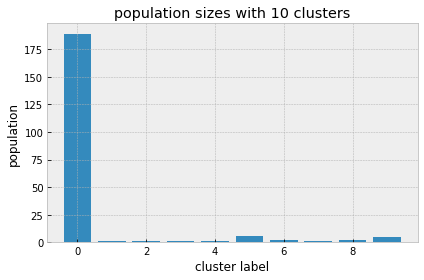

In [30]:
fig, ax = plt.subplots()

ax.bar(range(len(set(model.labels_))), np.bincount(model.labels_))

ax.set_ylabel('population')
ax.set_xlabel('cluster label')
ax.set_title('population sizes with {} clusters'.format(ks[0]))
    
fig.tight_layout()

Users are grouped into 10 clusters based on the contents of their tweets.

In [31]:
user_tweets['cluster'] = model.labels_

Cluster sizes:

In [38]:
sizes = (user_tweets
       .groupby('cluster')
       .size()
       .sort_values(ascending=False)
       )
sizes

cluster
0    189
5      6
9      5
8      2
6      2
7      1
4      1
3      1
2      1
1      1
dtype: int64

In [42]:
idx = sizes.index[0]

top_cluster = (user_tweets
           .groupby('cluster')
           .get_group(idx)['tweet_text']
           .apply(long_string)
          )
top_cluster.head(5)

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its people must be reformed https://t.co/DupN3cE2dd https://t.co/ee5KZJMm5R Portland Police Bureau is pr...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه خاک تو سرش.\nلطفا کسانی که واسه ایران و مردم سیل زده کمک نکردند نظر ندن.\n\n🔘پهباد سه تا ۱۰۰۰۰۰ یور...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must change!\n#PortlandProtest\nhttps://t.co/qydIlgjWK6 Hello bankrupt economy ..... Goodbye Trump #TrumpHas...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante carretera en Brasil para protestar tanto contra la deforestación del Amazonas.\n#Brasileirao \n#Bol...
1099221870530961408                             Droit de vote à 16ans, vous êtes ?\nEt pourquoi ?\n#TousContreMacron #demopolitique 🔴\nQuoi de neuf ?\nRassemblement en cours de la fonction publi...
Nam

This word cloud shows the frequent word tokens used by users in the largest cluster:

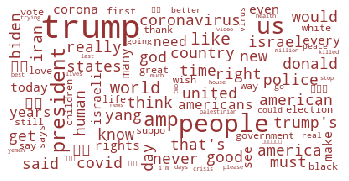

In [33]:
fig = tokens_from_series(top_cluster)

In [34]:
idx = sizes.i
cluster = (user_tweets
           .groupby('cluster')
           .get_group(idx)['tweet_text']
           .apply(long_string)
          )
cluster.head(5)

userid
213589457    ¡Quedan 3 episodios para el final!\nSerie "El profeta José"\nTodos los días a las 19:00 GMT\nSe repite a las 23:00,... http://t.co/xOk7IWgN Nicara...
Name: tweet_text, dtype: object

This cloud shows tokens from the second-largest cluster:

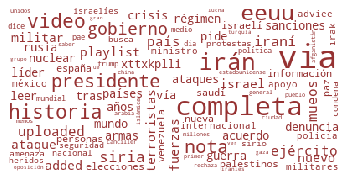

In [35]:
fig = tokens_from_series(cluster)